In [2]:
import os
import time
import warnings
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import mlflow
from lightgbm import LGBMClassifier
from rich import print
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    PrecisionRecallDisplay,
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    learning_curve
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

%load_ext rich
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
path ="../data/raw/spotify_songs_train.csv"

In [4]:
def prepare_data(data, date_column='track_album_release_date', target='track_popularity', test_size=0.2):
  
    data[date_column] = pd.to_datetime(data[date_column], errors='coerce')
    not_null_mask = data[date_column].dt.month.notnull() & data[date_column].dt.day.notnull()
    data = data[not_null_mask]
    data = data.dropna()
    X = data.drop(columns=[target])
    y = (data[target] > 50).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test


data = pd.read_csv(path)  
X_train, X_test, y_train, y_test = prepare_data(data)

In [5]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 22269

Test set size: 5568

## Feature engineering


In [6]:
class TopArtistTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_artists=10):
        self.num_top_artists = num_top_artists
        self.top_artists = None

    def fit(self, X, y=None):
        X["release_date__year"] = pd.to_datetime(
            X["track_album_release_date"], errors="coerce"
        ).dt.year
        songs_last_decade = X[
            X["release_date__year"] >= X["release_date__year"].max() - 10
        ]

        top_artists = (
            songs_last_decade.groupby("track_artist")
            .agg({"track_id": "count"})
            .rename(
                columns={
                    "track_id": "number_of_tracks",
                }
            )
        )

        top_artists = top_artists.sort_values(
            ["number_of_tracks"], ascending=[False]
        ).head(self.num_top_artists)

        self.top_artists = top_artists.index

        return self

    def transform(self, X):
        is_top_artist = X["track_artist"].isin(self.top_artists)
        return is_top_artist.to_frame(name="is_top_artist")

    def get_feature_names_out(self, input_features=None):
        return ["is_top_artist"]

In [7]:
def get_num_playlists(X):
    num_playlist = X.groupby("track_id")["playlist_id"].transform("nunique").values

    return np.column_stack([num_playlist])


def playlist_name(X, feature_names):
    return ["num_playlists"]


def release_date(X):
    X = pd.to_datetime(X, errors="coerce")

    month = X.dt.month
    day = X.dt.day

    month_season = month.map(
        {
            1: "Winter",
            2: "Winter",
            3: "Spring",
            4: "Spring",
            5: "Spring",
            6: "Summer",
            7: "Summer",
            8: "Summer",
            9: "Fall",
            10: "Fall",
            11: "Fall",
            12: "Winter",
        }
    )

    day_category = pd.cut(day, bins=[0, 10, 20, 31], labels=["First 10", "Middle 10", "Last 10"], right=False)

    return np.column_stack([month_season, day_category])


def release_date_name(X, feature_names):
    return ["month_season", "day_category"]


def get_is_remix_or_collab(X):
    is_remix = X.str.contains("remix", case=False).astype(int)
    is_collab = X.str.contains(r"(feat|ft\.|\(with)", case=False).astype(int)
    return np.column_stack([is_remix, is_collab])


def is_remix_or_collab_name(X, feature_names):
    return ["is_remix", "is_collab"]


def get_is_weekend(X):
    X = pd.to_datetime(X, errors="coerce")
    return X.dt.dayofweek.isin([5, 6]).astype(int).values.reshape(-1, 1)


def is_weekend_name(X, feature_names):
    return ["is_weekend"]


num_playlist_pipeline = make_pipeline(
    FunctionTransformer(
        get_num_playlists,
        validate=False,
        feature_names_out=playlist_name,
    ),
    StandardScaler(),
)

release_date_pipeline = make_pipeline(
    FunctionTransformer(
        release_date, validate=False, feature_names_out=release_date_name
    ),
    OneHotEncoder(handle_unknown="ignore"),
)

num_pipeline = make_pipeline(
    StandardScaler(),
)


feature_engineering = ColumnTransformer(
    [
        # (
        #     "num_playlists",
        #     num_playlist_pipeline,
        #     ["track_id", "playlist_id"],
        # ),
        (
            "release_date",
            release_date_pipeline,
            "track_album_release_date",
        ),
        (
            "release_day",
            FunctionTransformer(
                get_is_weekend, validate=False, feature_names_out=is_weekend_name
            ),
            "track_album_release_date",
        ),
        (
            "top_artist",
            TopArtistTransformer(num_top_artists=50),
            [
                "track_artist",
                "track_album_release_date",
                "track_id",
            ],
        ),
        (
            "genres",
            OneHotEncoder(handle_unknown="ignore"),
            ["playlist_genre", "playlist_subgenre"],
        ),
        (
            "track_name",
            FunctionTransformer(
                get_is_remix_or_collab,
                validate=False,
                feature_names_out=is_remix_or_collab_name,
            ),
            "track_name",
        ),
        (
            "numerical",
            num_pipeline,
            [
                "danceability",
                "energy",
                "loudness",
                "speechiness",
                "acousticness",
                "instrumentalness",
                "liveness",
                "valence",
                "tempo",
                "duration_ms",
            ],
        ),
        (
            "key",
            OrdinalEncoder(),
            ["key"],
        ),
        ("mode", "passthrough", ["mode"]),
    ],
    remainder="drop",
)

In [8]:
feature_engineering.fit(X_train)
with open('feature_engineering.pkl', 'wb') as f:
    pickle.dump(feature_engineering, f)

with open('train_test_data.pkl', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)


## Model building


In [32]:
estimators = [
    ("knn", KNeighborsClassifier(weights="distance", n_neighbors=10, algorithm="auto")),
    (
        "rf",
        RandomForestClassifier(
            n_estimators=400, min_samples_split=2, max_depth=30, random_state=42
        ),
    ),
    ("gnb", GaussianNB(var_smoothing=1e-09)),
    (
        "gbc",
        GradientBoostingClassifier(
            n_estimators=300, max_depth=7, learning_rate=0.2, random_state=42
        ),
    ),
    (
        "dt",
        DecisionTreeClassifier(
            min_samples_split=5, min_samples_leaf=1, max_depth=10, random_state=42
        ),
    ),
    (
        "lgb",
        LGBMClassifier(
            learning_rate=0.5, max_depth=-1, n_estimators=100, random_state=42, num_leaves=31
        ),
    ),
    ("xgb", XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=1000)),
]

final_estimator = LogisticRegression(random_state=42)

stacked_model = StackingClassifier(
    estimators=estimators, final_estimator=final_estimator, n_jobs=-1, verbose=2, cv=5, passthrough=True
)

stacked_model


StackingClassifier(cv=5,
                   estimators=[('knn',
                                KNeighborsClassifier(n_neighbors=10,
                                                     weights='distance')),
                               ('rf',
                                RandomForestClassifier(max_depth=30,
                                                       n_estimators=400,
                                                       random_state=42)),
                               ('gnb', GaussianNB()),
                               ('gbc',
                                GradientBoostingClassifier(learning_rate=0.2,
                                                           max_depth=7,
                                                           n_estimators=300,
                                                           random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=10,
                                                       min_samples...
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=1000, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression(random_state=42),
                   n_jobs=-1, passthrough=True, verbose=2)

In [33]:
pipeline = make_pipeline(feature_engineering, stacked_model)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('release_date',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function release_date_name at 0x1772e85e0>,
                                                                                       func=<function release_date at 0x1772e8540>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  'track_album_release_date'),
                                                 ('release_day',
                                                  Fu...
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=7,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=1000,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...))],
                                    final_estimator=LogisticRegression(random_state=42),
                                    n_jobs=-1, passthrough=True, verbose=2))])

In [34]:
print(pipeline)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('release_date',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function 
release_date_name at 0x1772e85e0>,
                                                                                       func=<function release_date 
at 0x1772e8540>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  'track_album_release_date'),
                                                 ('release_day',
                                                  Fu...
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=7,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=1000,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...))],
                                    final_estimator=LogisticRegression(random_state=42),
                                    n_jobs=-1, passthrough=True, verbose=2))])

In [ ]:
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=pipeline,
#     X=X_train,
#     y=y_train,
#     train_sizes=np.linspace(0.1, 1.0, 5),
#     n_jobs=-1,
#     verbose=2,
#     random_state=42,
# )

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# plt.figure()
# plt.title("Learning Curve")
# plt.xlabel("Training examples")
# plt.ylabel("Score")
# plt.grid()

# plt.fill_between(
#     train_sizes,
#     train_scores_mean - train_scores_std,
#     train_scores_mean + train_scores_std,
#     color="r",
#     alpha=0.1,
# )
# plt.fill_between(
#     train_sizes,
#     test_scores_mean - test_scores_std,
#     test_scores_mean + test_scores_std,
#     color="g",
#     alpha=0.1,
# )

# plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
# plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

# plt.legend(loc="best")
# plt.savefig("../reports/figures/learning_curve.png", dpi=300, bbox_inches="tight")
# plt.show()


In [12]:
start_time = time.time()
pipeline.fit(X_train, y_train)
end_time = time.time()

print("Model trained in {:.2f} seconds".format(end_time - start_time))
pipeline

[LightGBM] [Info] Number of positive: 9541, number of negative: 12728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 22269, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428443 -> initscore=-0.288206
[LightGBM] [Info] Start training from score -0.288206


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with

[LightGBM] [Info] Number of positive: 7632, number of negative: 10183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 17815, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428403 -> initscore=-0.288370
[LightGBM] [Info] Start training from score -0.288370
[LightGBM] [Info] Number of positive: 7633, number of negative: 10182
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 17815, number of used features: 54
[LightGBM] [Info] [b

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   29.7s remaining:   44.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.9s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   59.2s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.9s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Model trained in 193.10 seconds

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('release_date',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function release_date_name at 0x177e731a0>,
                                                                                       func=<function release_date at 0x177e73100>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  'track_album_release_date'),
                                                 ('release_day',
                                                  Fu...
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=7,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=1000,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...))],
                                    final_estimator=LogisticRegression(random_state=42),
                                    n_jobs=-1, verbose=2))])

In [13]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.75      0.81      0.77      3231
           1       0.70      0.62      0.66      2337

    accuracy                           0.73      5568
   macro avg       0.72      0.71      0.72      5568
weighted avg       0.73      0.73      0.73      5568

In [14]:
print("Performance on validation set:")

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")

Performance on validation set:

Accuracy: 0.7277298850574713

Precision: 0.6974506974506974

Recall: 0.6204535729567822

F1: 0.6567028985507247

ROC AUC: 0.7128885011178215

## Performance on unseen data


In [15]:
test_data = pd.read_csv("../data/raw/spotify_songs_isolated_sample.csv")
test_X, test_Y = (
    test_data.drop(columns=["track_popularity"]),
    (test_data["track_popularity"] > 50).astype(int),
)

test_Y_pred = pipeline.predict(test_X)

print(classification_report(test_Y, test_Y_pred))

precision    recall  f1-score   support

           0       0.74      0.82      0.78      1882
           1       0.72      0.61      0.66      1401

    accuracy                           0.73      3283
   macro avg       0.73      0.72      0.72      3283
weighted avg       0.73      0.73      0.73      3283

In [16]:
print("Performance on test set:")
print(f"Accuracy: {accuracy_score(test_Y, test_Y_pred)}")
print(f"Precision: {precision_score(test_Y, test_Y_pred)}")
print(f"Recall: {recall_score(test_Y, test_Y_pred)}")
print(f"F1: {f1_score(test_Y, test_Y_pred)}")
print(f"ROC AUC: {roc_auc_score(test_Y, test_Y_pred)}")

Performance on test set:

Accuracy: 0.7349984770027413

Precision: 0.7229219143576826

Recall: 0.6145610278372591

F1: 0.6643518518518519

ROC AUC: 0.7196078252895115

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:18                                                                                   │
│                                                                                                  │
│   15 plt.title("ROC-AUC curve")                                                                  │
│   16 plt.legend(loc="lower right")                                                               │
│   17                                                                                             │
│ ❱ 18 plt.savefig("../plots/roc_auc_curve.png", dpi=300, bbox_inches="tight")                     │
│   19                                                                                             │
│   20 plt.show()                                                                                  │
│   21                                                                                             │
│                                                                                                  │
│ /Users/yyy/Library/CloudStorage/OneDrive-Personal/MMA/2024WINTER1/INSY695/Spotify-Music/.venv/li │
│ b/python3.11/site-packages/matplotlib/pyplot.py:1023 in savefig                                  │
│                                                                                                  │
│   1020 @_copy_docstring_and_deprecators(Figure.savefig)                                          │
│   1021 def savefig(*args, **kwargs):                                                             │
│   1022 │   fig = gcf()                                                                           │
│ ❱ 1023 │   res = fig.savefig(*args, **kwargs)                                                    │
│   1024 │   fig.canvas.draw_idle()  # Need this if 'transparent=True', to reset colors.           │
│   1025 │   return res                                                                            │
│   1026                                                                                           │
│                                                                                                  │
│ /Users/yyy/Library/CloudStorage/OneDrive-Personal/MMA/2024WINTER1/INSY695/Spotify-Music/.venv/li │
│ b/python3.11/site-packages/matplotlib/figure.py:3343 in savefig                                  │
│                                                                                                  │
│   3340 │   │   │   │   │   stack.enter_context(                                                  │
│   3341 │   │   │   │   │   │   ax.patch._cm_set(facecolor='none', edgecolor='none'))             │
│   3342 │   │   │                                                                                 │
│ ❱ 3343 │   │   │   self.canvas.print_figure(fname, **kwargs)                                     │
│   3344 │                                                                                         │
│   3345 │   def ginput(self, n=1, timeout=30, show_clicks=True,                                   │
│   3346 │   │   │      mouse_add=MouseButton.LEFT,                                                │
│                                                                                                  │
│ /Users/yyy/Library/CloudStorage/OneDrive-Personal/MMA/2024WINTER1/INSY695/Spotify-Music/.venv/li │
│ b/python3.11/site-packages/matplotlib/backend_bases.py:2366 in print_figure                      │
│                                                                                                  │
│   2363 │   │   │   │   # _get_renderer may change the figure dpi (as vector formats              │
│   2364 │   │   │   │   # force the figure dpi to 72), so we need to set it again here.           │
│   2365 │   │   │   │   with cbook._setattr_cm(self.figure, dpi=dpi):                             │
│ ❱ 2366 │   │   │   │   │   result = print_method(          

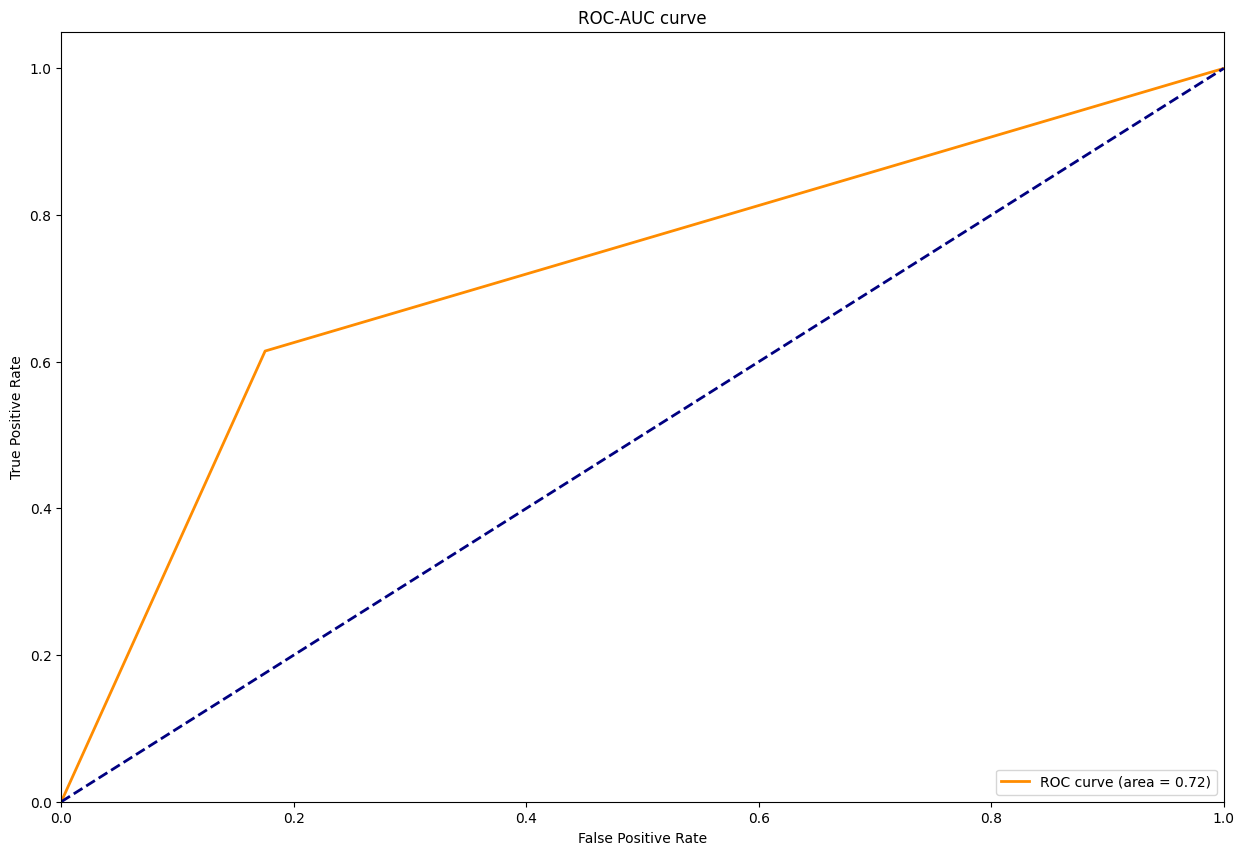

In [17]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_Y, test_Y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15, 10))
lw = 2
plt.plot(
    fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC curve")
plt.legend(loc="lower right")

plt.savefig("../reports/figures/roc_auc_curve.png", dpi=300, bbox_inches="tight")

plt.show()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6 _ = pr_curve.ax_.set_title("Precision-Recall curve")                                        │
│    7 _ = pr_curve.figure_.set_size_inches(15, 10)                                                │
│    8                                                                                             │
│ ❱  9 pr_curve.figure_.savefig(                                                                   │
│   10 │   "../plots/precision_recall_curve.png", dpi=300, bbox_inches="tight"                     │
│   11 )                                                                                           │
│   12                                                                                             │
│                                                                                                  │
│ /Users/yyy/Library/CloudStorage/OneDrive-Personal/MMA/2024WINTER1/INSY695/Spotify-Music/.venv/li │
│ b/python3.11/site-packages/matplotlib/figure.py:3343 in savefig                                  │
│                                                                                                  │
│   3340 │   │   │   │   │   stack.enter_context(                                                  │
│   3341 │   │   │   │   │   │   ax.patch._cm_set(facecolor='none', edgecolor='none'))             │
│   3342 │   │   │                                                                                 │
│ ❱ 3343 │   │   │   self.canvas.print_figure(fname, **kwargs)                                     │
│   3344 │                                                                                         │
│   3345 │   def ginput(self, n=1, timeout=30, show_clicks=True,                                   │
│   3346 │   │   │      mouse_add=MouseButton.LEFT,                                                │
│                                                                                                  │
│ /Users/yyy/Library/CloudStorage/OneDrive-Personal/MMA/2024WINTER1/INSY695/Spotify-Music/.venv/li │
│ b/python3.11/site-packages/matplotlib/backend_bases.py:2366 in print_figure                      │
│                                                                                                  │
│   2363 │   │   │   │   # _get_renderer may change the figure dpi (as vector formats              │
│   2364 │   │   │   │   # force the figure dpi to 72), so we need to set it again here.           │
│   2365 │   │   │   │   with cbook._setattr_cm(self.figure, dpi=dpi):                             │
│ ❱ 2366 │   │   │   │   │   result = print_method(                                                │
│   2367 │   │   │   │   │   │   filename,                                                         │
│   2368 │   │   │   │   │   │   facecolor=facecolor,                                              │
│   2369 │   │   │   │   │   │   edgecolor=edgecolor,                                              │
│                                                                                                  │
│ /Users/yyy/Library/CloudStorage/OneDrive-Personal/MMA/2024WINTER1/INSY695/Spotify-Music/.venv/li │
│ b/python3.11/site-packages/matplotlib/backend_bases.py:2232 in <lambda>                          │
│                                                                                                  │
│   2229 │   │   │   │   "dpi", "facecolor", "edgecolor", "orientation",                           │
│   2230 │   │   │   │   "bbox_inches_restore"}                                                    │
│   2231 │   │   │   skip = optional_kws - {*inspect.signature(meth).parameters}                   │
│ ❱ 2232 │   │   │   print_method = functools.wraps(meth)(lam

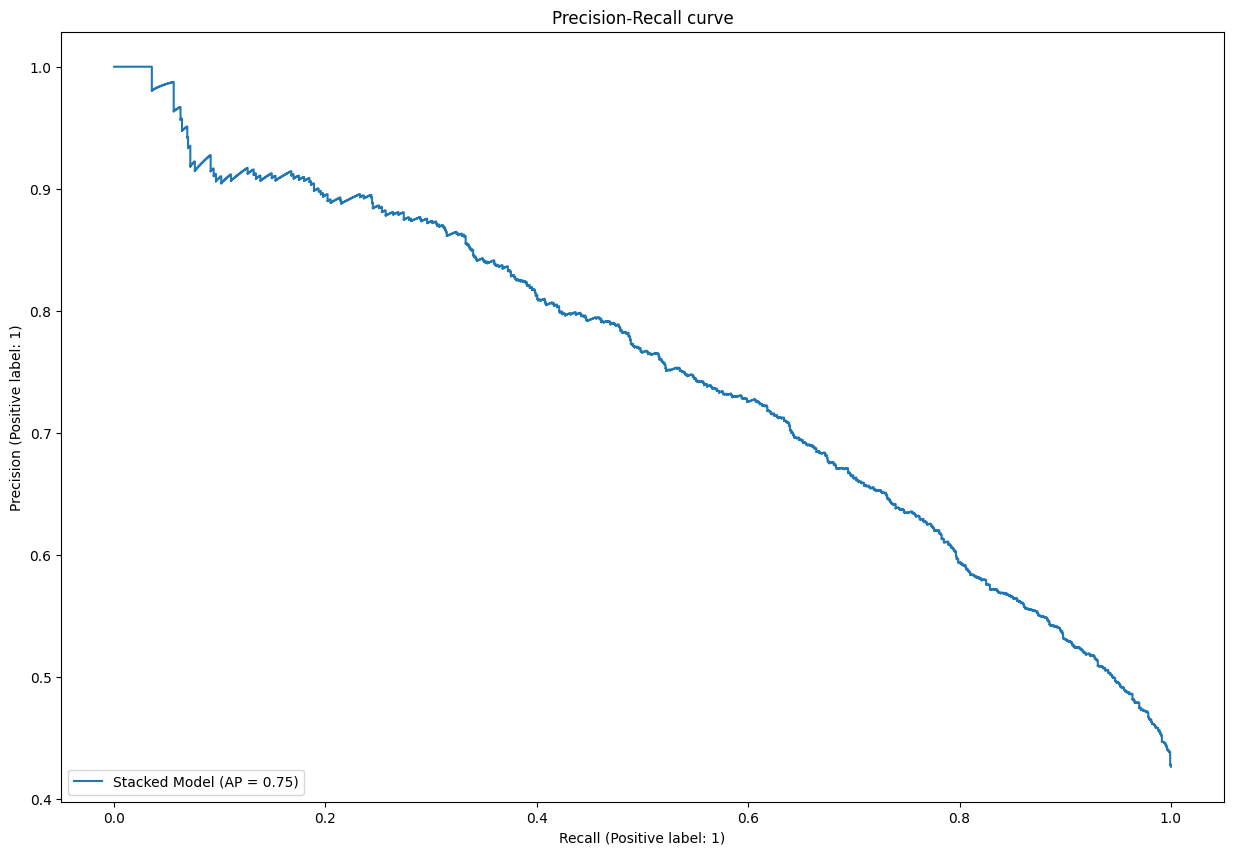

In [18]:
# Plot Precision-Recall curve
pr_curve = PrecisionRecallDisplay.from_estimator(
    pipeline, test_X, test_Y, name="Stacked Model"
)

_ = pr_curve.ax_.set_title("Precision-Recall curve")
_ = pr_curve.figure_.set_size_inches(15, 10)

pr_curve.figure_.savefig(
    "../reports/figures/precision_recall_curve.png", dpi=300, bbox_inches="tight"
)


## Model comparison


In [19]:
stacked_model_estimators = stacked_model.estimators_
reports = {}

test_X_transformed = pipeline.named_steps["columntransformer"].transform(test_X)


for estimator in stacked_model_estimators:
    print(f"Report for: {estimator.__class__.__name__}")

    pred_Y = estimator.predict(test_X_transformed)

    print(classification_report(test_Y, pred_Y))

    report = {
        "accuracy": accuracy_score(test_Y, pred_Y),
        "precision": precision_score(test_Y, pred_Y),
        "recall": recall_score(test_Y, pred_Y),
        "f1": f1_score(test_Y, pred_Y),
        "roc_auc": roc_auc_score(test_Y, pred_Y),
        "confusion_matrix": confusion_matrix(test_Y, pred_Y),
    }

    reports[estimator.__class__.__name__] = report

Report for: KNeighborsClassifier

precision    recall  f1-score   support

           0       0.71      0.74      0.72      1882
           1       0.63      0.59      0.61      1401

    accuracy                           0.67      3283
   macro avg       0.67      0.66      0.66      3283
weighted avg       0.67      0.67      0.67      3283

Report for: RandomForestClassifier

precision    recall  f1-score   support

           0       0.73      0.83      0.77      1882
           1       0.72      0.59      0.65      1401

    accuracy                           0.72      3283
   macro avg       0.72      0.71      0.71      3283
weighted avg       0.72      0.72      0.72      3283

Report for: GaussianNB

precision    recall  f1-score   support

           0       0.72      0.62      0.67      1882
           1       0.57      0.67      0.62      1401

    accuracy                           0.64      3283
   macro avg       0.64      0.65      0.64      3283
weighted avg       0.66      0.64      0.65      3283

Report for: GradientBoostingClassifier

precision    recall  f1-score   support

           0       0.73      0.78      0.76      1882
           1       0.68      0.62      0.65      1401

    accuracy                           0.71      3283
   macro avg       0.71      0.70      0.70      3283
weighted avg       0.71      0.71      0.71      3283

Report for: DecisionTreeClassifier

precision    recall  f1-score   support

           0       0.70      0.72      0.71      1882
           1       0.61      0.58      0.60      1401

    accuracy                           0.66      3283
   macro avg       0.65      0.65      0.65      3283
weighted avg       0.66      0.66      0.66      3283

Report for: LGBMClassifier

precision    recall  f1-score   support

           0       0.72      0.77      0.75      1882
           1       0.67      0.60      0.63      1401

    accuracy                           0.70      3283
   macro avg       0.70      0.69      0.69      3283
weighted avg       0.70      0.70      0.70      3283

Report for: XGBClassifier

precision    recall  f1-score   support

           0       0.75      0.80      0.77      1882
           1       0.70      0.64      0.67      1401

    accuracy                           0.73      3283
   macro avg       0.73      0.72      0.72      3283
weighted avg       0.73      0.73      0.73      3283

In [20]:
y_pred_stacked = pipeline.predict(test_X)

reports["stacked_model"] = {
    "accuracy": accuracy_score(test_Y, y_pred_stacked),
    "precision": precision_score(test_Y, y_pred_stacked),
    "recall": recall_score(test_Y, y_pred_stacked),
    "f1": f1_score(test_Y, y_pred_stacked),
    "roc_auc": roc_auc_score(test_Y, y_pred_stacked),
    "confusion_matrix": confusion_matrix(test_Y, y_pred_stacked),
}

In [21]:
reports = pd.DataFrame(reports).T

In [22]:
reports

,accuracy,precision,recall,f1,roc_auc,confusion_matrix
KNeighborsClassifier,0.673774,0.625571,0.586724,0.605525,0.66265,"[[1390, 492], [579, 822]]"
RandomForestClassifier,0.724947,0.716146,0.588865,0.646298,0.707557,"[[1555, 327], [576, 825]]"
GaussianNB,0.643923,0.570303,0.671663,0.616847,0.647468,"[[1173, 709], [460, 941]]"
GradientBoostingClassifier,0.712763,0.680315,0.616702,0.646949,0.700487,"[[1476, 406], [537, 864]]"
DecisionTreeClassifier,0.662504,0.609574,0.581727,0.595325,0.652181,"[[1360, 522], [586, 815]]"
LGBMClassifier,0.701797,0.665881,0.604568,0.633745,0.689372,"[[1457, 425], [554, 847]]"
XGBClassifier,0.731039,0.704259,0.637402,0.669164,0.719073,"[[1507, 375], [508, 893]]"
stacked_model,0.734998,0.722922,0.614561,0.664352,0.719608,"[[1552, 330], [540, 861]]"


# ML Flow

In [ ]:
# Set MLflow experiment
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment('Spotify Song Popularity Prediction')


# Start MLflow run
mlflow.start_run()

mlflow.autolog()

# Log only the common important params
for key, value in pipeline.get_params().items():
    if key.startswith("stackingclassifier"):
        mlflow.log_param(key, value)

start_time = time.time()
pipeline.fit(X_train, y_train)
end_time = time.time()
mlflow.log_metric("training_time", end_time - start_time)

# Log model accuracy (example from cell 23)
metrics = {
    "accuracy": accuracy_score(y_train, pipeline.predict(X_train)),
    "precision": precision_score(y_train, pipeline.predict(X_train)),
    "recall": recall_score(y_train, pipeline.predict(X_train)),
    "f1": f1_score(y_train, pipeline.predict(X_train)),
    "roc_auc": roc_auc_score(y_train, pipeline.predict(X_train)),
}

mlflow.log_metrics(metrics)

mlflow.sklearn.log_model(pipeline, "model")

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1,
    verbose=2,
    random_state=42,
)

train_sizes_dict = {f"train_size_{i}": size for i, size in enumerate(train_sizes)}
train_scores_mean_dict = {f"train_score_mean_{i}": score for i, score in enumerate(np.mean(train_scores, axis=1))}
train_scores_std_dict = {f"train_score_std_{i}": score for i, score in enumerate(np.std(train_scores, axis=1))}
test_scores_mean_dict = {f"test_score_mean_{i}": score for i, score in enumerate(np.mean(test_scores, axis=1))}
test_scores_std_dict = {f"test_score_std_{i}": score for i, score in enumerate(np.std(test_scores, axis=1))}

mlflow.log_metrics("train_sizes", train_sizes_dict)
mlflow.log_metrics("train_scores_mean", train_scores_mean_dict)
mlflow.log_metrics("train_scores_std", train_scores_std_dict)
mlflow.log_metrics("test_scores_mean", test_scores_mean_dict)
mlflow.log_metrics("test_scores_std", test_scores_std_dict)

# mlflow.log_artifact("../reports/figures/learning_curve.png")


# Log the model
mlflow.sklearn.log_model(pipeline, "model")

mlflow.end_run()



In [48]:
mlflow.end_run()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6 axs = axs.flatten()[:-1]  # Use only 5 subplots, ignore the last one                        │
│    7                                                                                             │
│    8 # Determine the order of x labels based on the first metric to ensure consistency across    │
│ ❱  9 sorted_index = reports["accuracy"].sort_values(ascending=False).index                       │
│   10                                                                                             │
│   11 # Define a color palette                                                                    │
│   12 # Use a single color for all but the stacked_model, which will be highlighted in a diffe    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'reports' is not defined

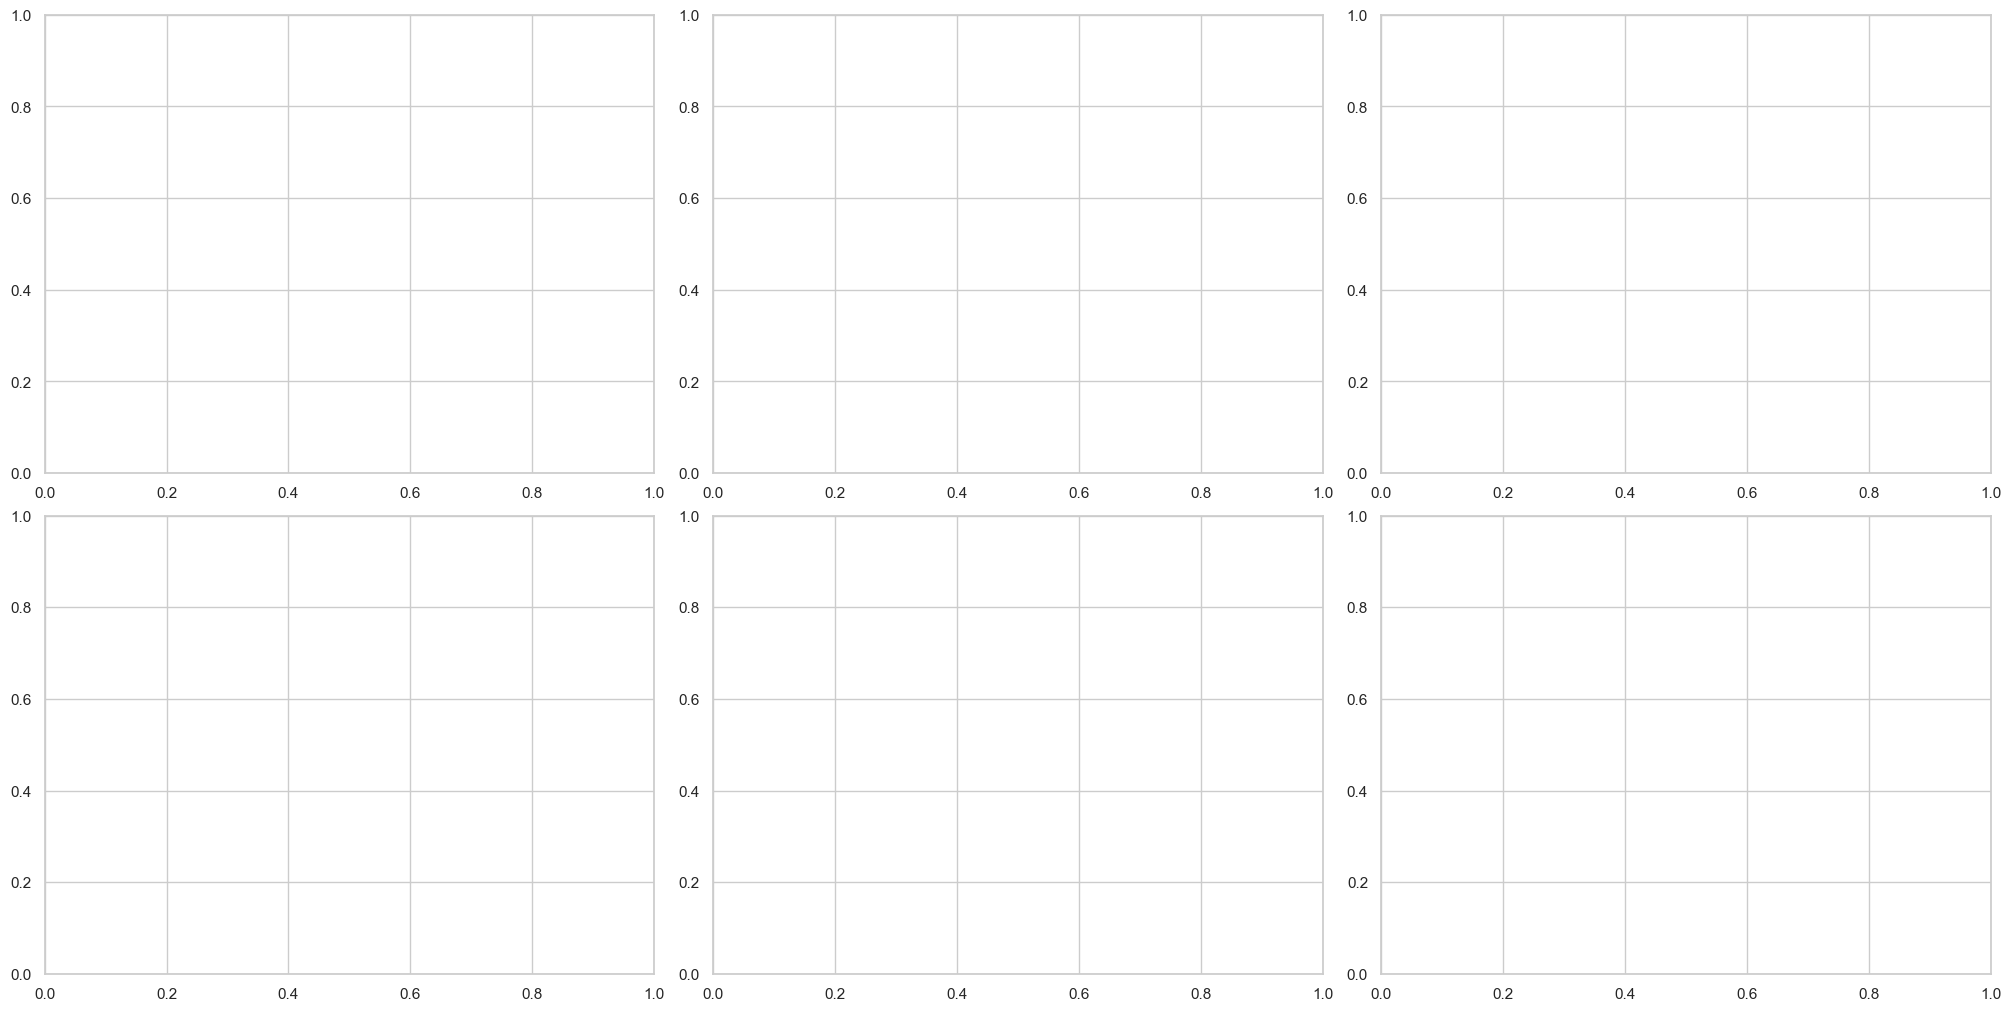

In [31]:
# Set the aesthetics for the plots
sns.set_theme(style="whitegrid")

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), constrained_layout=True)
axs = axs.flatten()[:-1]  # Use only 5 subplots, ignore the last one

# Determine the order of x labels based on the first metric to ensure consistency across all plots
sorted_index = reports["accuracy"].sort_values(ascending=False).index

# Define a color palette
# Use a single color for all but the stacked_model, which will be highlighted in a different color
base_color = sns.color_palette("coolwarm", len(sorted_index))[
    0
]  # Use the first color for all
highlight_color = "yellow"  # Highlight color for the stacked_model
palette = [
    highlight_color if model == "stacked_model" else base_color
    for model in sorted_index
]

# Plot each metric for each model
for i, metric in enumerate(["accuracy", "precision", "recall", "f1", "roc_auc"]):
    sns.barplot(
        x=sorted_index, y=reports.loc[sorted_index, metric], ax=axs[i], palette=palette
    )
    axs[i].set_title(metric.upper(), fontsize=16)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha="right")
    axs[i].set_ylabel(metric.upper(), fontsize=14)
    axs[i].set_xlabel("")

# Adjust layout and add a tight layout to manage space
plt.suptitle("Model comparison", fontsize=20)
plt.tight_layout()



mlflow.log_artifact("../reports/figures/model_comparison.png")
plt.savefig("../reports/figures/model_comparison.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

## Hyperparameter tuning

We present the code for hyperparameter tuning here. The actual tuning was done on a Colab notebook.


In [25]:
## Takes a long time to run, please be patient...

# Initialize pipelines dictionary
pipelines = {}
for name, estimator in estimators:
    pipelines[name] = Pipeline(
        [("feature_engg", feature_engineering), (name, estimator)]
    )

# Updated parameter grids, organized by estimator key
param_grid = {
    "knn": {
        "knn__n_neighbors": [3, 5, 7, 10],
        "knn__weights": ["uniform", "distance"],
        "knn__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    },
    "rf": {
        "rf__n_estimators": [100, 200, 300, 400],
        "rf__max_depth": [10, 20, 30],
        "rf__min_samples_split": [2, 5, 10],
    },
    "gnb": {
        "gnb__var_smoothing": [1e-9, 1e-8, 1e-10],
    },
    "gbc": {
        "gbc__n_estimators": [100, 200, 300],
        "gbc__learning_rate": [0.01, 0.1, 0.2],
        "gbc__max_depth": [3, 5, 7],
    },
    "dt": {
        "dt__max_depth": [10, 20, 30],
        "dt__min_samples_split": [2, 5, 10],
        "dt__min_samples_leaf": [1, 2, 4],
    },
    "lgb": {
        "lgb__n_estimators": [100, 500, 1000],
        "lgb__learning_rate": [0.01, 0.1, 0.5],
        "lgb__max_depth": [3, 5, 7, 10],
    },
    "xgb": {
        "xgb__n_estimators": [100, 500, 1000],
        "xgb__learning_rate": [0.01, 0.1, 0.5],
        "xgb__max_depth": [3, 5, 7, 10],
    },
}

searches = {}

for name, pipeline in pipelines.items():
    # Retrieve the parameter grid for the current estimator
    estimator_param_grid = param_grid[name]

    search = GridSearchCV(
        estimator=pipeline,
        param_grid=estimator_param_grid,
        scoring="accuracy",  # Use 'f1' for scoring, consider 'f1_macro' or 'f1_weighted' for multi-class
        n_jobs=-1,
        cv=5,
        verbose=2,
    )

    searches[name] = search

results = []

# Fit each search object to perform hyperparameter tuning for each pipeline and collect results
for name, search in searches.items():
    print(f"Starting GridSearchCV for {name}...")
    search.fit(X_train, y_train)  # Ensure X_train and y_train are defined
    print(f"Best parameters for {name}: {search.best_params_}")
    print(f"Best score for {name}: {search.best_score_}")

    # Append the results to the list
    results.append(
        {
            "Model": name,
            "Best Parameters": search.best_params_,
            "Best Score": search.best_score_,
        }
    )

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
results_df

Starting GridSearchCV for knn...

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular

[CV] END knn__algorithm=auto, knn__n_neighbors=3, knn__weights=uniform; total time=   2.2s
[CV] END knn__algorithm=auto, knn__n_neighbors=3, knn__weights=uniform; total time=   2.2s
[CV] END knn__algorithm=auto, knn__n_neighbors=3, knn__weights=distance; total time=   2.2s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=3, knn__weights=distance; total time=   2.3s
[CV] END knn__algorithm=auto, knn__n_neighbors=3, knn__weights=uniform; total time=   2.7s
[CV] END knn__algorithm=auto, knn__n_neighbors=3, knn__weights=distance; total time=   2.4s
[CV] END knn__algorithm=auto, knn__n_neighbors=3, knn__weights=uniform; total time=   2.6s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular

[CV] END knn__algorithm=auto, knn__n_neighbors=3, knn__weights=uniform; total time=   2.7s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=3, knn__weights=distance; total time=   2.5s
[CV] END knn__algorithm=auto, knn__n_neighbors=3, knn__weights=distance; total time=   2.9s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=uniform; total time=   3.3s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=uniform; total time=   3.4s
[CV] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=uniform; total time=   3.5s
[CV] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=uniform; total time=   3.5s
[CV] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=uniform; total time=   3.6s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular

[CV] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=distance; total time=   3.1s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=distance; total time=   2.9s
[CV] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=distance; total time=   2.9s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=distance; total time=   2.6s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=distance; total time=   2.7s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=7, knn__weights=uniform; total time=   3.0s
[CV] END knn__algorithm=auto, knn__n_neighbors=7, knn__weights=uniform; total time=   2.9s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=7, knn__weights=uniform; total time=   3.2s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=7, knn__weights=uniform; total time=   3.1s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=7, knn__weights=distance; total time=   2.7s
[CV] END knn__algorithm=auto, knn__n_neighbors=7, knn__weights=uniform; total time=   3.3s
[CV] END knn__algorithm=auto, knn__n_neighbors=7, knn__weights=distance; total time=   2.6s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=7, knn__weights=distance; total time=   2.5s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=7, knn__weights=distance; total time=   2.7s
[CV] END knn__algorithm=auto, knn__n_neighbors=7, knn__weights=distance; total time=   2.7s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=10, knn__weights=uniform; total time=   2.9s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=10, knn__weights=uniform; total time=   3.1s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=10, knn__weights=uniform; total time=   2.9s
[CV] END knn__algorithm=auto, knn__n_neighbors=10, knn__weights=uniform; total time=   2.9s
[CV] END knn__algorithm=auto, knn__n_neighbors=10, knn__weights=distance; total time=   2.5s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=10, knn__weights=uniform; total time=   3.1s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=10, knn__weights=distance; total time=   2.4s
[CV] END knn__algorithm=auto, knn__n_neighbors=10, knn__weights=distance; total time=   2.4s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular

[CV] END knn__algorithm=auto, knn__n_neighbors=10, knn__weights=distance; total time=   2.4s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[CV] END knn__algorithm=auto, knn__n_neighbors=10, knn__weights=distance; total time=   2.2s


/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_34229/1781801907.py:45: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:69                                                                                   │
│                                                                                                  │
│   66 # Fit each search object to perform hyperparameter tuning for each pipeline and collect     │
│   67 for name, search in searches.items():                                                       │
│   68 │   print(f"Starting GridSearchCV for {name}...")                                           │
│ ❱ 69 │   search.fit(X_train, y_train)  # Ensure X_train and y_train are defined                  │
│   70 │   print(f"Best parameters for {name}: {search.best_params_}")                             │
│   71 │   print(f"Best score for {name}: {search.best_score_}")                                   │
│   72                                                                                             │
│                                                                                                  │
│ /Users/yyy/Library/CloudStorage/OneDrive-Personal/MMA/2024WINTER1/INSY695/Spotify-Music/.venv/li │
│ b/python3.11/site-packages/sklearn/model_selection/_search.py:874 in fit                         │
│                                                                                                  │
│    871 │   │   │   │                                                                             │
│    872 │   │   │   │   return results                                                            │
│    873 │   │   │                                                                                 │
│ ❱  874 │   │   │   self._run_search(evaluate_candidates)                                         │
│    875 │   │   │                                                                                 │
│    876 │   │   │   # multimetric is determined here because in the case of a callable            │
│    877 │   │   │   # self.scoring the return type is only known after calling                    │
│                                                                                                  │
│ /Users/yyy/Library/CloudStorage/OneDrive-Personal/MMA/2024WINTER1/INSY695/Spotify-Music/.venv/li │
│ b/python3.11/site-packages/sklearn/model_selection/_search.py:1388 in _run_search                │
│                                                                                                  │
│   1385 │                                                                                         │
│   1386 │   def _run_search(self, evaluate_candidates):                                           │
│   1387 │   │   """Search all candidates in param_grid"""                                         │
│ ❱ 1388 │   │   evaluate_candidates(ParameterGrid(self.param_grid))                               │
│   1389                                                                                           │
│   1390                                                                                           │
│   1391 class RandomizedSearchCV(BaseSearchCV):                                                   │
│                                                                                                  │
│ /Users/yyy/Library/CloudStorage/OneDrive-Personal/MMA/2024WINTER1/INSY695/Spotify-Music/.venv/li │
│ b/python3.11/site-packages/sklearn/model_selection/_search.py:821 in evaluate_candidates         │
│                                                                                                  │
│    818 │   │   │   │   │   │   )                                                                 │
│    819 │   │   │   │   │   )                                                                     │
│    820 │   │   │   │                                                                             │
│ ❱  821 │   │   │   │   out = parallel(                     

## Model explainability

We use SHAP to explain the feature importance from the stacked classifier model.


In [ ]:
shap.initjs()

explainer = shap.KernelExplainer(
    pipeline.named_steps["stackingclassifier"].predict_proba,
    shap.sample(
        pipeline.named_steps["columntransformer"].transform(X_train),
        10000,
        random_state=42,
    ),
    nsamples=100,
    link="logit",
)

<IPython.core.display.HTML object>

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Using 10000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
X_test_transformed = pipeline.named_steps["columntransformer"].transform(test_X)

# Calculate SHAP values
# Takes a very long time to run - please be patient...

shap_values = explainer.shap_values(
    shap.sample(
        X_test_transformed,
        10,
        random_state=42,
    ),
    nsamples=100,
    gc_collect=True,
)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 10%|█         | 1/10 [02:38<23:44, 158.24s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 20%|██        | 2/10 [04:53<19:19, 144.90s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 30%|███       | 3/10 [07:04<16:07, 138.26s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 40%|████      | 4/10 [09:18<13:40, 136.80s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 50%|█████     | 5/10 [11:33<11:20, 136.00s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 60%|██████    | 6/10 [13:49<09:04, 136.20s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 70%|███████   | 7/10 [16:03<06:45, 135.21s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 80%|████████  | 8/10 [18:19<04:30, 135.50s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 90%|█████████ | 9/10 [20:31<02:14, 134.35s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


100%|██████████| 10/10 [22:41<00:00, 136.17s/it]


In [ ]:
explainer.expected_value

array([ 0.24355804, -0.24355804])

In [ ]:
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][4, :],
    pd.DataFrame(
        X_test_transformed,
        columns=pipeline.named_steps["columntransformer"].get_feature_names_out(),
    ).iloc[4, :],
    link="logit",
)


<shap.plots._force.AdditiveForceVisualizer object at 0x00000170CC920F10>

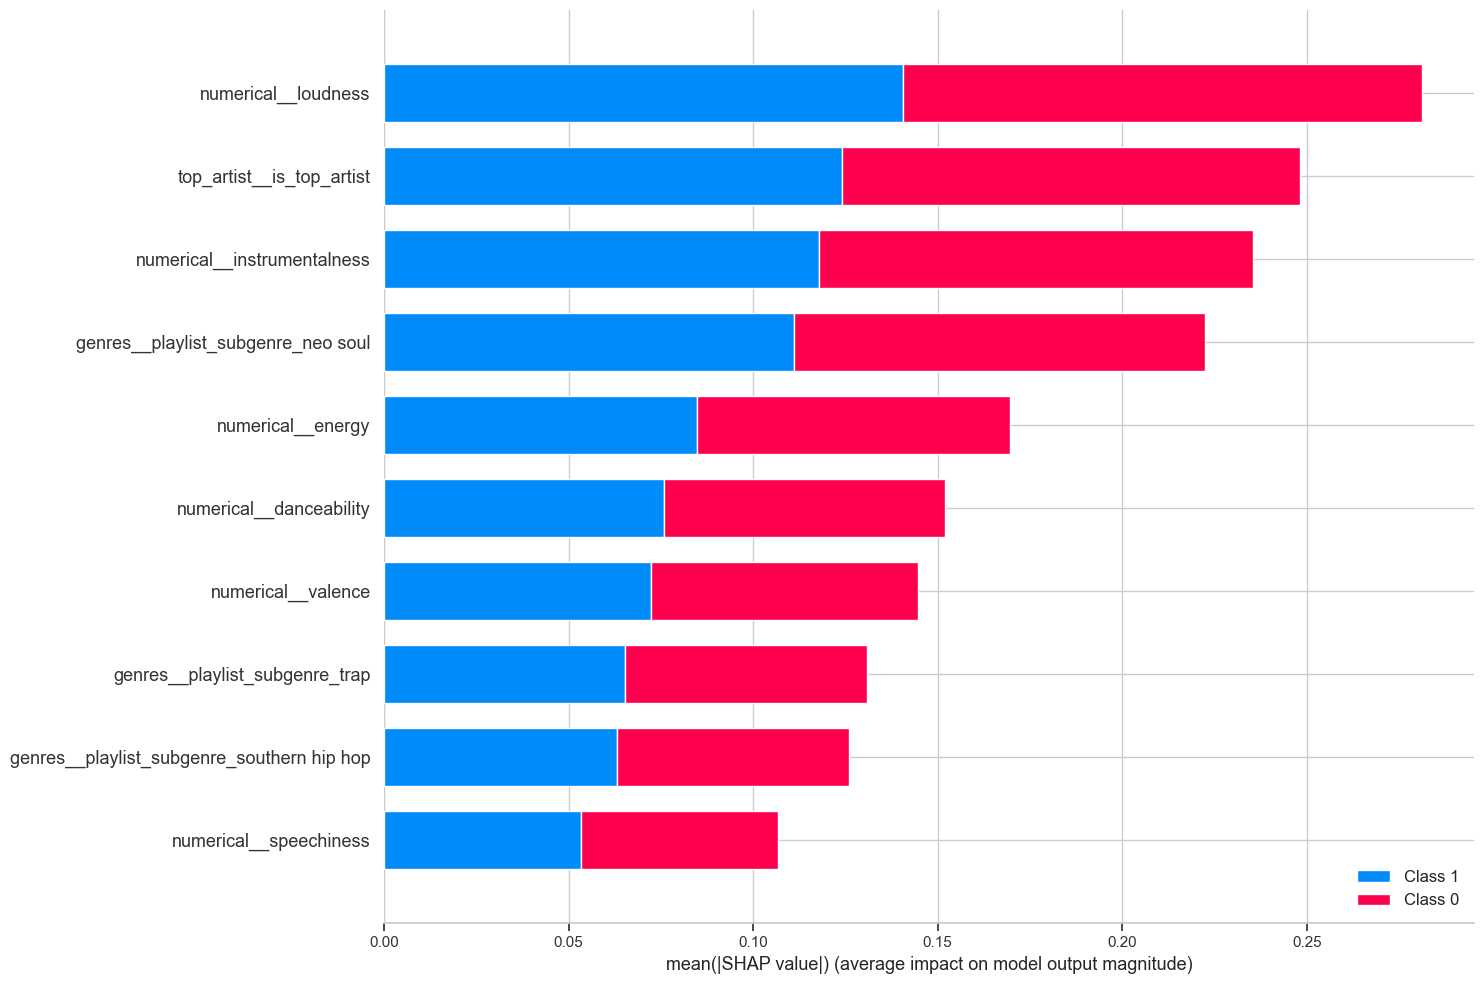

In [ ]:
shap.summary_plot(
    shap_values,
    pd.DataFrame(
        shap.sample(
            X_test_transformed,
            10,
            random_state=42,
        ),
        columns=pipeline.named_steps["columntransformer"].get_feature_names_out(),
    ),
    title="SHAP Summary Plot",
    plot_type="bar",
    max_display=10,
    plot_size=(15, 10),
)
